In [1]:
import pandas as pd

df = pd.read_stata("/Users/franciscoazzollini/repos/datascientist-politicalparties-python/data/CHES2019V3.dta")


In [2]:
df.head()

,country,eastwest,party,party_id,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_blur,eu_cohesion,...,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership,eu_econ_require,eu_political_require,eu_googov_require
0,be,1.0,PS,102.0,6.083333,0.288675,4.272727,2.75,2.166667,6.250,...,6.000000,0.111111,2.111111,3.363636,2.181818,1.909091,7.500000,NaN,NaN,NaN
1,be,1.0,SP/SPA,103.0,6.000000,0.426401,4.181818,2.50,1.714286,6.000,...,5.333333,0.111111,2.222222,3.545455,2.090909,1.636364,6.818182,NaN,NaN,NaN
2,be,1.0,ECOLO,104.0,6.583333,0.514929,4.818182,2.50,1.428571,6.000,...,6.166667,0.111111,2.888889,5.636364,2.454545,2.363636,3.909091,NaN,NaN,NaN
3,be,1.0,AGALEV,105.0,6.583333,0.514929,4.818182,2.50,1.285714,5.875,...,6.083333,0.111111,2.777778,5.636364,2.363636,2.000000,4.000000,NaN,NaN,NaN
4,be,1.0,PRL/MR,106.0,6.500000,0.674200,5.090909,2.00,1.714286,5.500,...,6.416667,0.111111,2.333333,4.636364,1.727273,1.636364,7.000000,NaN,NaN,NaN


In [3]:
df.shape

(277, 55)

In [4]:
empty_counts = df.isna().sum()
print(empty_counts)


country                    0
eastwest                  30
party                      0
party_id                   0
eu_position                0
eu_position_sd             0
eu_salience                0
eu_dissent                 2
eu_blur                    1
eu_cohesion               30
eu_foreign                31
eu_intmark                30
eu_budgets                31
eu_asylum                 31
lrgen                      0
lrecon                     0
lrecon_sd                  0
lrecon_salience            0
lrecon_dissent             2
lrecon_blur                3
galtan                     0
galtan_sd                  0
galtan_salience            0
galtan_dissent             8
galtan_blur                2
immigrate_policy           0
immigrate_salience         0
immigrate_dissent          1
multiculturalism           0
multicult_salience         1
multicult_dissent          1
redistribution             1
redist_salience            0
environment                0
enviro_salienc

In [5]:
df.iloc[0].T

country                        be
eastwest                      1.0
party                          PS
party_id                    102.0
eu_position              6.083333
eu_position_sd           0.288675
eu_salience              4.272727
eu_dissent                   2.75
eu_blur                  2.166667
eu_cohesion                  6.25
eu_foreign               5.444445
eu_intmark               4.777778
eu_budgets                   4.25
eu_asylum                5.555555
lrgen                    2.083333
lrecon                       2.25
lrecon_sd                0.621582
lrecon_salience          8.166667
lrecon_dissent                2.2
lrecon_blur              1.142857
galtan                   2.916667
galtan_sd                1.378954
galtan_salience               4.0
galtan_dissent                2.5
galtan_blur                  2.75
immigrate_policy         3.416667
immigrate_salience           4.25
immigrate_dissent             3.4
multiculturalism         3.083333
multicult_sali

In [20]:
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture


class DensityEstimator:
    """Class to estimate Density/Distribution of the given data.
    1. Write a function to model the distribution of the political party dataset
    2. Write a function to randomly sample 10 parties from this distribution
    3. Map the randomly sampled 10 parties back to the original higher dimensional
    space as per the previously used dimensionality reduction technique.
    """

    def __init__(self, data: pd.DataFrame, dim_reducer, high_dim_feature_names):
        self.data = data
        self.dim_reducer_model = dim_reducer.model
        self.feature_names = high_dim_feature_names

    # Alternative: KernelDensity from sklearn.neighbors for non-parametric estimation
    def fit_distribution(self, n_components: int = 3, random_state: int = 0) -> GaussianMixture:
        model = GaussianMixture(
            n_components=n_components,
            covariance_type="full",
            random_state=random_state,
        )
        model.fit(self.data.values)
        self.gmm_ = model
        return model

    def sample_parties(self, n_samples: int = 10, random_state: int = 0) -> Tuple[pd.DataFrame, np.ndarray]:
        if not hasattr(self, "gmm_"):
            raise RuntimeError("Call fit_distribution() before sampling")
        rng = np.random.RandomState(random_state)
        samples, labels = self.gmm_.sample(n_samples)
        sampled_df = pd.DataFrame(samples, columns=self.data.columns)
        return sampled_df, labels

    def invert_to_high_dim(self, low_dim_df: pd.DataFrame) -> pd.DataFrame:
        # Inverse transform back to original feature space if supported by the reducer
        if hasattr(self.dim_reducer_model, "inverse_transform"):
            high_dim = self.dim_reducer_model.inverse_transform(low_dim_df.values)
            return pd.DataFrame(high_dim, columns=self.feature_names)
        # Alternative: train a regressor per high-dim feature to map from low-dim → high-dim
        raise NotImplementedError("Dimensionality reducer does not support inverse_transform")



In [7]:

from political_party_analysis.loader import DataLoader
from political_party_analysis.dim_reducer import DimensionalityReducer

data_loader = DataLoader()
# Data pre-processing step
processed_df = data_loader.preprocess_data()

# Dimensionality reduction step
dim_reducer = DimensionalityReducer("PCA", processed_df, n_components=2)
reduced_dim_data = dim_reducer.transform()

In [40]:
estimator = DensityEstimator(reduced_dim_data, dim_reducer, processed_df.columns)
gmm = estimator.fit_distribution(n_components=3)
sampled_df, labels = estimator.sample_parties(n_samples=10)



/Users/franciscoazzollini/venv313/lib/python3.13/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


In [41]:
sampled_df

,component_1,component_2
0,-2.913597,5.698105
1,-4.125654,-0.365556
2,-2.371903,1.350243
3,-0.280718,2.617009
4,-1.008354,4.459512
5,5.451252,-0.137126
6,6.177591,-0.438441
7,3.953769,0.729481
8,-4.829649,-1.859306
9,-2.606764,-8.268050


/Users/franciscoazzollini/venv313/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Users/franciscoazzollini/repos/datascientist-politicalparties-python/src/political_party_analysis/visualization.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  splot.legend()


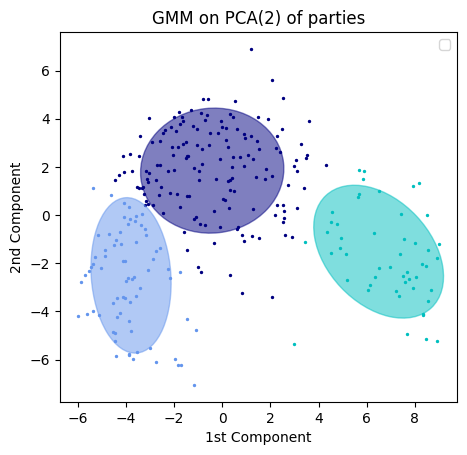

In [ ]:
from political_party_analysis.visualization import (
    plot_density_estimation_results,
    plot_finnish_parties,
    scatter_plot,
)
plot_density_estimation_results(
        reduced_dim_data,
        gmm.predict(reduced_dim_data),
        gmm.means_,
        gmm.covariances_,
        title="GMM on PCA(2) of parties",
    )